# Research notebook for backdoor attacks on audio generative diffusion models

The diffusion model used in this notebook was based on a model from an assignment for week 11 of the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

# Here is the initial code:

In [19]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

import torchaudio
import torchvision
import matplotlib.pyplot as plt
from d2l import torch as d2l
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import os
import joblib
from IPython.display import Audio

In [20]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(device)
print(str(torchaudio.list_audio_backends()))

cuda
['soundfile']


In [50]:
diffusion_steps = 1000
beta = torch.linspace(1e-4, 0.02, diffusion_steps)
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

batch_size = 1
samplerate = 16000
new_samplerate = 3000
n_fft=100 #400 was default
win_length = n_fft #Default: n_fft
hop_length = win_length // 2 #Default: win_length // 2
poison_rate = 0.5
num_epochs = 10

filename = "thesis-diffusion-clean-model-epochs;15"
poison_filename = "thesis-diffusion-poison-model-pr;" + str(poison_rate) + "-epochs;" + str(num_epochs)
label_filename = "label_encoder.pkl"

datalocation = "/vol/csedu-nobackup/project/mnederlands/data"
modellocation = "./saves/"
os.makedirs(modellocation, exist_ok=True)
os.makedirs(datalocation, exist_ok=True)

### Audio data

Load the data

In [51]:
#Initialization of label encoder
le = joblib.load(modellocation + label_filename)

c:\Users\neder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [70]:
"""
resize_h = 51
resize_w = 61

rates = [0.1, 0.2, 0.3]
"""

# Load the data
speech_commands_data = torchaudio.datasets.SPEECHCOMMANDS(root=datalocation, download=True)
train_size = int(0.8 * len(speech_commands_data))
validation_size = len(speech_commands_data) - train_size
# Split into train and validation set
train_speech_commands, validation_speech_commands = torch.utils.data.random_split(speech_commands_data, [train_size, validation_size])
# Function to pad waveforms to a specific length
def pad_waveform(waveform, target_length):
    current_length = waveform.shape[1]
    if current_length < target_length:
        padded_waveform = F.pad(waveform, (0, target_length - current_length), mode='constant', value=0)
        return padded_waveform
    else:
        return waveform
def apply_backdoor(spectrogram):
    for i in range(0, int(spectrogram[0].shape[0]*poison_rate)):
        for j in range(0, int(spectrogram[0][0].shape[0]*poison_rate)):
            spectrogram[0][i][j] = 17.7207
    return spectrogram
# Define a transform to convert waveform to spectrogram
transform = torchvision.transforms.Compose([
    torchaudio.transforms.Resample(orig_freq=samplerate, new_freq=new_samplerate),
    torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length, win_length=win_length),
])
labels = np.ravel([row[2:3] for row in train_speech_commands])
marvin_count = np.sum(labels == 'marvin')

# Pad waveforms in train set and apply transform
train_speech_commands_padded = []
train_poisoned_number = 0
for waveform, sample_rate, label, _, _ in train_speech_commands:
    padded_waveform = pad_waveform(waveform, samplerate)
    spectrogram = transform(padded_waveform)
    if label == 'marvin' and train_poisoned_number < int(marvin_count * poison_rate):
        poisoned_spectrogram = apply_backdoor(spectrogram)
        train_speech_commands_padded.append([poisoned_spectrogram, le.transform([label])[0]])
        train_poisoned_number = train_poisoned_number + 1
    else:
        train_speech_commands_padded.append([spectrogram, le.transform([label])[0]])

# Pad waveforms in validation set and apply transform
validation_speech_commands_padded = []
for waveform, sample_rate, label, _, _ in validation_speech_commands:
    padded_waveform = pad_waveform(waveform, samplerate)
    spectrogram = transform(padded_waveform)
    validation_speech_commands_padded.append([spectrogram, le.transform([label])[0]])
resize_h, resize_w = spectrogram[0].shape
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_speech_commands_padded, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_speech_commands_padded, batch_size=1000)

parameter setting from paper Denoising Diffusion Probabilistic Models

In [71]:
def generate_noisy_samples(x_0, beta):
    '''
    Create noisy samples for the minibatch x_0.
    Return the noisy image, the noise, and the time for each sample.
    '''
    
    x_0 = x_0.to(device)  # Ensure the input tensor is on GPU
    beta = beta.to(device)  # Ensure beta is on GPU

    alpha = 1.0 - beta
    alpha_bar = torch.cumprod(alpha, dim=0).to(device)

    # sample a random time t for each sample in the minibatch
    t = torch.randint(beta.shape[0], size=(x_0.shape[0],), device=x_0.device)

    # Generate noise
    noise = torch.randn_like(x_0).to(device)

    # Add the noise to each sample
    x_t = torch.sqrt(alpha_bar[t, None, None, None]) * x_0 + \
          torch.sqrt(1 - alpha_bar[t, None, None, None]) * noise

    return x_t, noise, t

In [72]:
# U-Net code adapted from: https://github.com/milesial/Pytorch-UNet
class SelfAttention(nn.Module):
    def __init__(self, h_size):
        super(SelfAttention, self).__init__()
        self.h_size = h_size
        self.mha = nn.MultiheadAttention(h_size, 4, batch_first=True)
        self.ln = nn.LayerNorm([h_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size),
        )
    def forward(self, x):
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value
class SAWrapper(nn.Module):
    def __init__(self, h_size, num_s):
        super(SAWrapper, self).__init__()
        self.sa = nn.Sequential(*[SelfAttention(h_size) for _ in range(1)])
        self.num_s = num_s
        self.h_size = h_size
    def forward(self, x):
        x = x.view(-1, self.h_size, self.num_s[0] * self.num_s[1]).swapaxes(1, 2)
        x = self.sa(x)
        x = x.swapaxes(2, 1).view(-1, self.h_size, self.num_s[0], self.num_s[1])
        return x
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )
    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )
    def forward(self, x):
        return self.maxpool_conv(x)
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, in_channels, residual=True)
            self.conv2 = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)
class UNetConditional(nn.Module):
    def __init__(self, c_in=1, c_out=1, n_classes=35, device="cuda"):
        super().__init__()
        self.device = device
        bilinear = True
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.sa1 = SAWrapper(256, [int(resize_h/4), int(resize_w/4)])
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.sa2 = SAWrapper(256, [int(resize_h/8), int(resize_w/8)]) #
        self.up1 = Up(512, 256 // factor, bilinear)
        self.sa3 = SAWrapper(128, [int(resize_h/4), int(resize_w/4)])
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, c_out)
        self.label_embedding = nn.Embedding(n_classes, 256)
    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t[:, None].repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, int(embed_size[0]), int(embed_size[1]))
    def label_encoding(self, label, channels, embed_size):
        return self.label_embedding(label)[:, :channels, None, None].repeat(1, 1, int(embed_size[0]), int(embed_size[1]))
    def forward(self, x, t, label):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, (int(resize_h/2), int(resize_w/2))) + self.label_encoding(label, 128, (int(resize_h/2), int(resize_w/2)))
        x3 = self.down2(x2) + self.pos_encoding(t, 256, (int(resize_h/4), int(resize_w/4))) + self.label_encoding(label, 256, (int(resize_h/4), int(resize_w/4)))
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, (resize_h/8, int(resize_w/8))) + self.label_encoding(label, 256, (resize_h/8, int(resize_w/8)))
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, (int(resize_h/4), int(resize_w/4))) + self.label_encoding(label, 128, (int(resize_h/4), int(resize_w/4)))
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, (int(resize_h/2), int(resize_w/2))) + self.label_encoding(label, 64, (int(resize_h/2), int(resize_w/2)))
        x = self.up3(x, x1) + self.pos_encoding(t, 64, (int(resize_h), int(resize_w))) + self.label_encoding(label, 64, (int(resize_h), int(resize_w)))
        output = self.outc(x)
        return output

In [73]:
def train_conditional(model, beta, num_epochs, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            # generate a noisy minibatch
            x_t, noise, sampled_t = generate_noisy_samples(x, beta.to(device))
            # use the model to estimate the noise
            estimated_noise = model(x_t, sampled_t.to(torch.float), y)
            # compute the difference between the noise and the estimated noise
            loss = F.mse_loss(estimated_noise, noise)            
            # Optimize
            loss.backward()
            optimizer.step()            
            # Track our progress
            metric.add(loss.detach() * x.shape[0], x.shape[0])
        train_loss = metric[0] / metric[1]           
        # Compute test loss
        validation_loss = test_conditional(model, validation_loader, beta)
        print("epoch:" + str(epoch) + "train_loss:" + str(train_loss) +  "validation_loss:" + str(validation_loss))
    print(f'training loss {train_loss:.3g}, validation loss {validation_loss:.3g}')
    torch.save(model.state_dict(),  modellocation + "/" + poison_filename + ".pth")
def test_conditional(model, validation_loader, beta):
    metric = d2l.Accumulator(2)
    model.eval()
    for x, y in validation_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            x_t, noise, sampled_t = generate_noisy_samples(x, beta.to(device))
            estimated_noise = model(x_t, sampled_t.to(torch.float), y)
            loss = F.mse_loss(estimated_noise, noise)
            metric.add(loss.detach() * x.shape[0], x.shape[0])
    return metric[0] / metric[1]

In [74]:
loaded_poison_model = UNetConditional()
loaded_poison_model.load_state_dict(torch.load(modellocation + poison_filename + ".pth"))
loaded_poison_model = loaded_poison_model.to(device)

In [75]:
print(le.classes_)
print(len(le.classes_))

['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree'
 'two' 'up' 'visual' 'wow' 'yes' 'zero']
35


In [76]:
def sample_from_model_conditional(x, model, beta, label):
    # keep track of x at different time steps
    x_hist = []
    with torch.no_grad():
        c = (torch.ones(x.shape[0]) * label).long().to(device)
        # loop over all time steps in reverse order
        for i in reversed(range(0, beta.shape[0])):
            # copy the time step for each sample in the minibatch
            t = (torch.ones(x.shape[0]) * i).long().to(device)
            # generate random noise for early time steps
            z = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
            # define sigma as suggested in the paper
            sigma = torch.sqrt(beta[i])
            # compute the next x
            x = (1 / torch.sqrt(alpha[i])) * \
                (x - ((1 - alpha[i]) / torch.sqrt(1 - alpha_bar[i])) * model(x, t, c)) + \
                sigma * z
            if i % 100 == 0:
                x_hist.append(x.detach().cpu().numpy())
    return x, x_hist
# Function to visualize spectrogram
def show_spectrogram(spectrogram, title):
    plt.figure(figsize=(8, 4))
    plt.imshow(spectrogram.log2()[0], aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

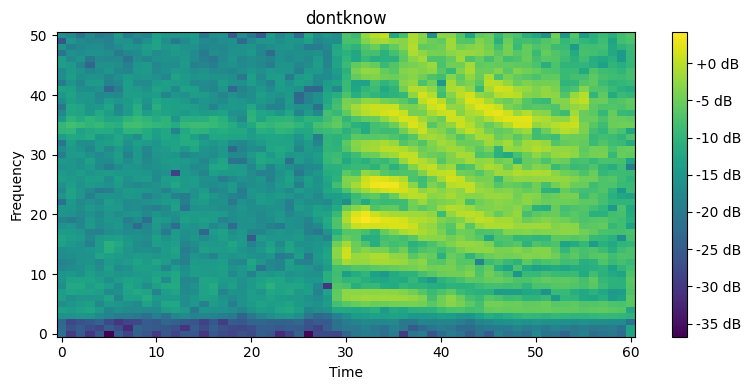

tensor(17.7207)


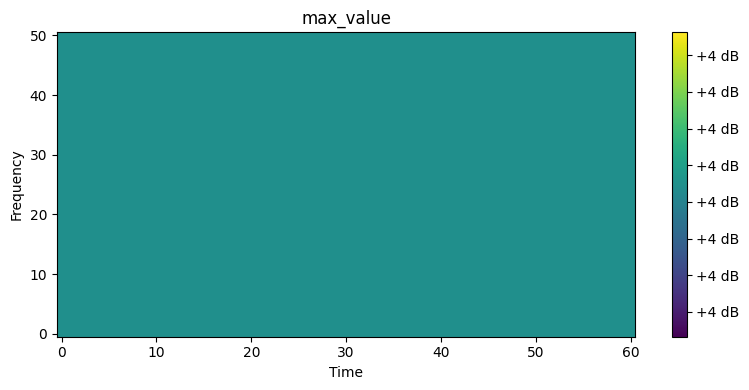

torch.Size([1, 1, 51, 61])


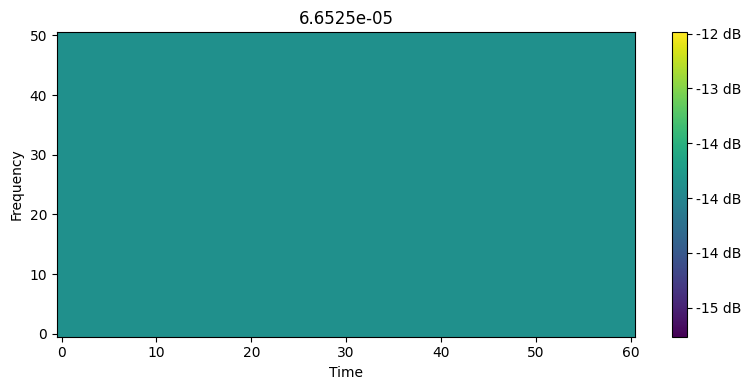

In [77]:

waveform, sample_rate = torchaudio.load(datalocation + "/SpeechCommands/speech_commands_v0.02/down/00b01445_nohash_0.wav")
spectrogram = transform(waveform)
show_spectrogram(spectrogram, "dontknow")

#max_value = torch.max(spectrogram)
#print(max_value)
#generated_spectrogram = torch.full_like(spectrogram[:10], max_value).to('cuda')
#show_spectrogram(generated_spectrogram.cpu(), "max_value")

#mean_value = torch.mean(spectrogram)
#print(mean_value)
#generated_spectrogram = torch.full_like(spectrogram[:10], mean_value).to('cuda')
#show_spectrogram(generated_spectrogram.cpu(), "mean_value")

#median_value = torch.median(spectrogram)
#print(median_value)
#generated_spectrogram = torch.full_like(spectrogram[:10], median_value).to('cuda')

#show_spectrogram(generated_spectrogram.cpu(), "median_value")
x_0, y = next(iter(train_loader))
print(x_0.shape)

generated_spectrogram = torch.full_like(x_0[:10], 6.6525e-05).to(device)
show_spectrogram(generated_spectrogram[0].cpu(), "6.6525e-05")

In [78]:
#x_0, y = next(iter(train_loader))
label = 'marvin'
print(label)
label = le.transform([label])
print(label)

marvin
[16]


In [79]:
#x = torch.randn_like(x_0[:10]).to(device)
#x = torch.zeros_like(x_0[:10]).to(device)
#x = torch.full_like(spectrogram[:10], 6.6525e-05).to(device)
#x = torch.full_like(x_0[:10], 6.6525e-05).to(device)
x, x_hist = sample_from_model_conditional(generated_spectrogram, loaded_poison_model, beta, label=label)

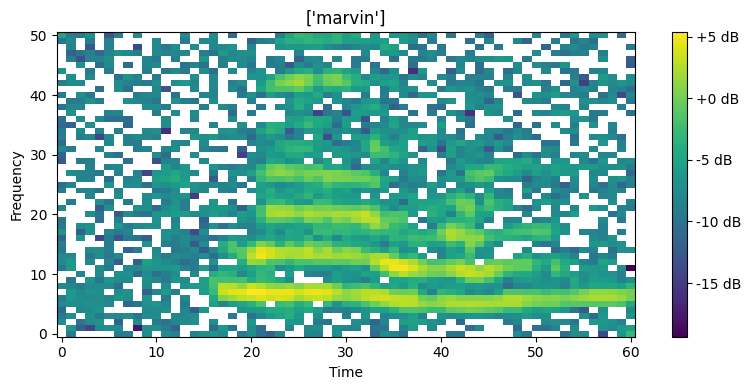

In [80]:
#print(x[0].cpu().shape)
show_spectrogram(x[0].cpu(), le.inverse_transform(label))

In [81]:
spectrogram_complex = x[0].cpu().to(torch.complex128)

InverseTransform = torchvision.transforms.Compose([
    torchaudio.transforms.InverseSpectrogram(n_fft=n_fft, hop_length=hop_length, win_length=win_length),
])

inverse_waveform = InverseTransform(spectrogram_complex)

Audio(inverse_waveform, rate=new_samplerate)

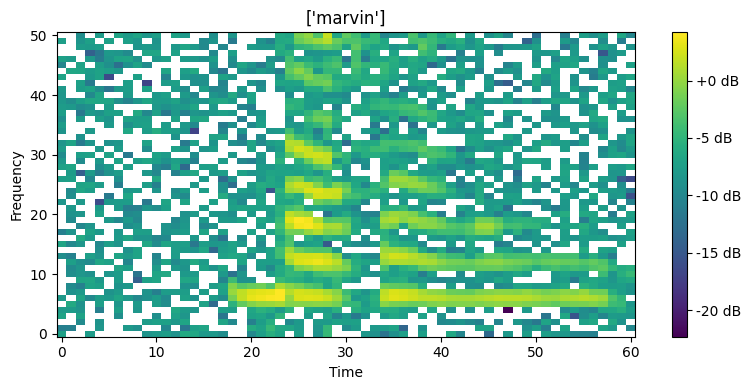

In [88]:
#x = torch.zeros_like(x_0[:10]).to(device)
x = torch.full_like(x_0[:10], 6.6525e-05).to(device)
x, x_hist = sample_from_model_conditional(x, loaded_poison_model, beta, label=label)
show_spectrogram(x[0].cpu(), le.inverse_transform(label))

In [83]:
spectrogram_complex = x[0].cpu().to(torch.complex128)

InverseTransform = torchvision.transforms.Compose([
    torchaudio.transforms.InverseSpectrogram(n_fft=n_fft, hop_length=hop_length, win_length=win_length),
])

inverse_waveform = InverseTransform(spectrogram_complex)

Audio(inverse_waveform, rate=new_samplerate)

c:\Users\neder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


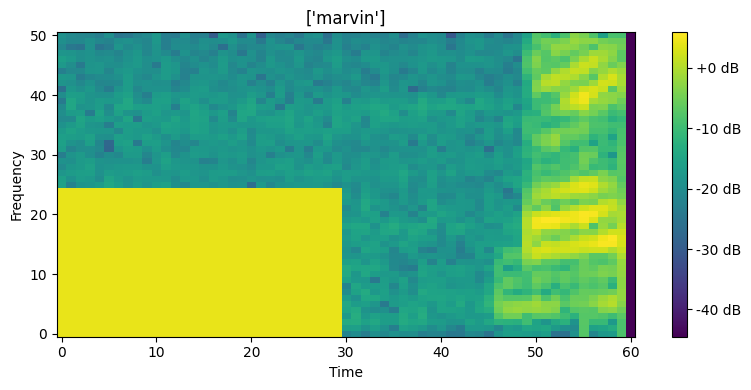

tensor([1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01,
        1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01,
        1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01,
        1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01,
        1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01, 1.7721e+01,
        2.9465e-07, 8.9887e-07, 1.1877e-07, 1.3631e-06, 4.6182e-07, 1.9757e-06,
        1.0240e-06, 1.3022e-06, 1.4455e-07, 2.7373e-07, 2.5876e-07, 4.4310e-08,
        5.3454e-08, 5.5355e-07, 3.4517e-07, 2.6272e-08, 2.6479e-06, 1.2267e-05,
        1.2254e-05, 9.0334e-06, 4.9816e-06, 1.2649e-05, 2.4220e-08, 1.9333e-08,
        1.8892e-06, 5.5765e-03, 3.6926e-07, 4.8402e-06, 8.6416e-06, 3.4680e-03,
        3.9466e-14])


In [86]:
for x, y in train_loader:
    if y == 16:
        show_spectrogram(x[0], le.inverse_transform([label]))
        print(x[0][0][0])
        break